In [1]:
# Import libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
def add_poly_terms(feat, n_feats=None, max_pot=5):
    # This function add polynomial terms up to max_pot power to the first n_feats
    # variables to the features' matrix up to the max_pot power
    n_samples = feat.shape[0]
    if n_feats is None:
        n_feats = feat.shape[1]
    feat_list = [feat]
    for pot in range(2, max_pot+1):
        feat_list +=  [np.reshape(feat[:,i]**pot, (n_samples,1)) for i in range(n_feats)]
    return np.concatenate(feat_list, axis=1)

def add_iter_terms(feat, n_feats=None):
    # This function add iteration terms of the first n_feats
    # variables to the features' matrix
    n_samples = feat.shape[0]
    if n_feats is None:
        n_feats = feat.shape[1]
    feat_list = [feat]
    for i in range(n_feats):
        for j in range(i+1,n_feats):
            feat_list += [np.reshape(feat[:,i]*feat[:,j], (n_samples,1))]
    return np.concatenate(feat_list, axis=1)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_rates(cm, classes):
    success_rate = []
    for i in range(len(cm)):
        success_rate.append(cm[i][i] / np.sum(cm[i]))
    
    x_pos = np.arange(len(classes))
    
    fig, ax = plt.subplots()    
    plt.bar(x_pos, success_rate)
    plt.xticks(x_pos, classes, rotation=45)
    ax.yaxis.set_visible(False)
    ax.axis([-1, 6, 0, 1.1])
    plt.title('Success rate for each class')
    #plt.ylabel('Success rate')
    for i, v in enumerate(success_rate):
        ax.text(i, v+0.01, format(success_rate[i], '.2f'),
                horizontalalignment="center",
                color='black', fontweight='bold')    
    plt.show()
    
# Eliminate NaN entries
def remove_nan(X):
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])
    
def normalize_data(X):
    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    return sc_X.fit_transform(X)

In [3]:
# read the data set
data_set = pd.read_csv('WISDM_ar_v1.1_transformed.csv')
X = data_set.iloc[:, 2:-1].values # eliminate not important colums 
y = data_set.iloc[:,-1].values

In [4]:
# Eliminate NaN entries
remove_nan(X)

In [5]:
# Feature scaling
X = normalize_data(X)

In [6]:
# Split the dataset into the Training set and the Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

# Dans ce Notebook on utilisera le classificateur RandomForest
# Ce classificateur est capable de améliorer la précision de la classification par raport à un seul classificateur d'arbre de décision au coût d'une perte d'interprétation du modèle

In [66]:
# 10-fold CV for determination of the hyperparameter 'min_samples_split'
def CV_min_samples_split():
    print('Cross validation for min_samples_split parameter selection:')
    for min_sample_split in range(2, 10):
        clf = RandomForestClassifier(n_estimators=300, max_depth=None,
            min_samples_split=min_sample_split, random_state=0)
        print('\tmin_sample_split = %d, acc= %f' %
              (min_sample_split, cross_val_score(clf, X_train, y_train, cv=10).mean()))
#CV_min_samples_split()
# the results showed that the highest CV score happens for min_sample_split = 2
# if you want to rerun the CV test uncomment the line above

In [7]:
# Perform k-fold CV for model assessment
# here we are using m = sqrt(p) when splitting a node to buil the tree
# and we are using the best result for min_samples_split given by CV executed above
# Note: the accuracy stops increasing after a certain number of trees without increasing overfitting
# so taking n_estimators very large is just fine (the only disadvantage is higher time to fit)
clf = RandomForestClassifier(n_estimators=300, max_depth=None,
    min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X_train, y_train, cv=10)

print('RandomForest classifier score on training set (10-fold CV): %f' % scores.mean())

RandomForest classifier score on training set (10-fold CV): 0.894813


# Nous pouvons voir que ce méthode nous a donné une 'accuracy' plus élevée que celles de LogisticRegression ou SVM 

In [8]:
# Fit the classifier on training set and predict results on test set
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('RandomForest classifier score on test set: %f' % (np.mean(y_pred == y_test,)))

RandomForest classifier score on test set: 0.889299


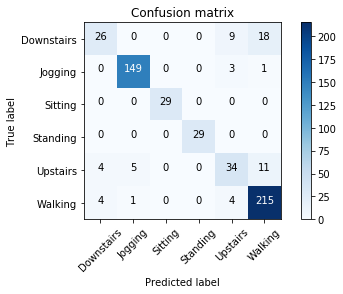

In [11]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=np.unique(y_train))

# On peut voir que pour les classes 'Jogging', 'Sitting', 'Standing' et 'Walking' le classificateur a eu un presque parfait résultat
# Le classificateur a eu encore du mal a différencier 'Downstairs' et 'Upstairs' de 'Walking', avec beaucoup de false-négatif pour 'Downstairs' et 'Upstairs' et beaucoup de false-positif pour 'Walking' 

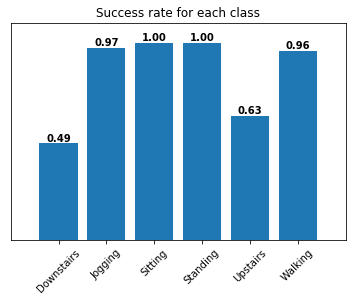

In [12]:
print_rates(cm, classes=np.unique(y_train))

In [13]:
# Here I expand the data set to include polynomial terms of the predictors and evaluate the result
X_extended = data_set.iloc[:, 2:-1].values
remove_nan(X_extended)
X_extended = add_poly_terms(X_extended, n_feats=43, max_pot=3)
X_extended = add_iter_terms(X_extended, n_feats=43)
X_extended = normalize_data(X_extended)

# Split the dataset into the Training set and the Test set
from sklearn.model_selection import train_test_split
X_traine, X_teste, y_traine, y_teste = train_test_split(X_extended, y, test_size=0.10, random_state=0)

# Perform k-fold CV for model assessment
clfe = RandomForestClassifier(n_estimators=300, max_depth=None,
    min_samples_split=2, random_state=0)
scorese = cross_val_score(clfe, X_traine, y_traine, cv=10)

print('CV score for RF model including polynomial terms: %f' % scorese.mean())

CV score for RF model including polynomial terms: 0.889892


In [14]:
clfe.fit(X_traine, y_traine)
print('RandomForest classifier score on training set with poly terms (10-fold CV): %f' % clfe.score(X_teste, y_teste))

RandomForest classifier score on training set with poly terms (10-fold CV): 0.876384


# We can notice that there wasn't an increase in accuracy after
# involving polynomial/interaction terms of the original features